In [1]:
!pip install -q kaggle
!pip install -U -q "google-generativeai>=0.8.3"
import zipfile
import os
from pathlib import Path
from keras.utils import load_img, img_to_array
import keras
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import enum
from google.colab import files
import google.generativeai as genai
from google.api_core import retry
import kagglehub
import math


files.upload()
data_dir = "~/.kaggle"
!mkdir -p {data_dir}
!cp kaggle.json {data_dir}/
!chmod 600 {data_dir}/kaggle.json
!kaggle datasets download -d rm1000/brain-tumor-mri-scans
dataset_path = "brain-tumor-mri-scans.zip"
extracted_path = "brain-tumor-mri-scans"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 95% 225M/236M [00:01<00:00, 127MB/s]
100% 236M/236M [00:01<00:00, 134MB/s]


In [2]:
api_key = "" #replace yours
genai.configure(api_key=api_key)

In [3]:

def print_directory_tree(startpath, max_depth=1, indent="    "):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        if level > max_depth:
            continue
        prefix = indent * level + "|-- "
        print(f"{prefix}{os.path.basename(root)}/")

dataset_path = "brain-tumor-mri-scans"
print("Dataset Directory Tree (Folders Only):")
print_directory_tree(dataset_path, max_depth=1)


Dataset Directory Tree (Folders Only):
|-- brain-tumor-mri-scans/
    |-- meningioma/
    |-- healthy/
    |-- glioma/
    |-- pituitary/


In [4]:
for model in genai.list_models():
    print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.0-flash-exp
models/gemini-exp-1206
models/gemini-exp-1121
models/gemini-exp-1114
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/learnlm-1.5-pro-experimental
models/embedding-001
models/text-embedding-004
models

In [5]:
retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

model = genai.GenerativeModel("gemini-1.5-flash-latest")

In [16]:
class TumorType(enum.Enum):
    glioma = "glioma"
    meningioma = "meningioma"
    pituitary = "pituitary"
    healthy = "healthy"

In [7]:
def load_two_images_per_class(dataset_dir, max_classes=15):
    images = []
    labels = []
    classes = os.listdir(dataset_dir)
    selected_classes = classes[:max_classes]
    for class_label in selected_classes:
        class_dir = os.path.join(dataset_dir, class_label)
        if not os.path.isdir(class_dir):
            continue
        image_files = os.listdir(class_dir)[:2]
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            try:
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return images, labels

In [8]:
data_dir = extracted_path
images, labels = load_two_images_per_class(data_dir, max_classes=15)
print(f"\nLoaded {len(images)} images from {len(set(labels))} classes.")


Loaded 8 images from 4 classes.


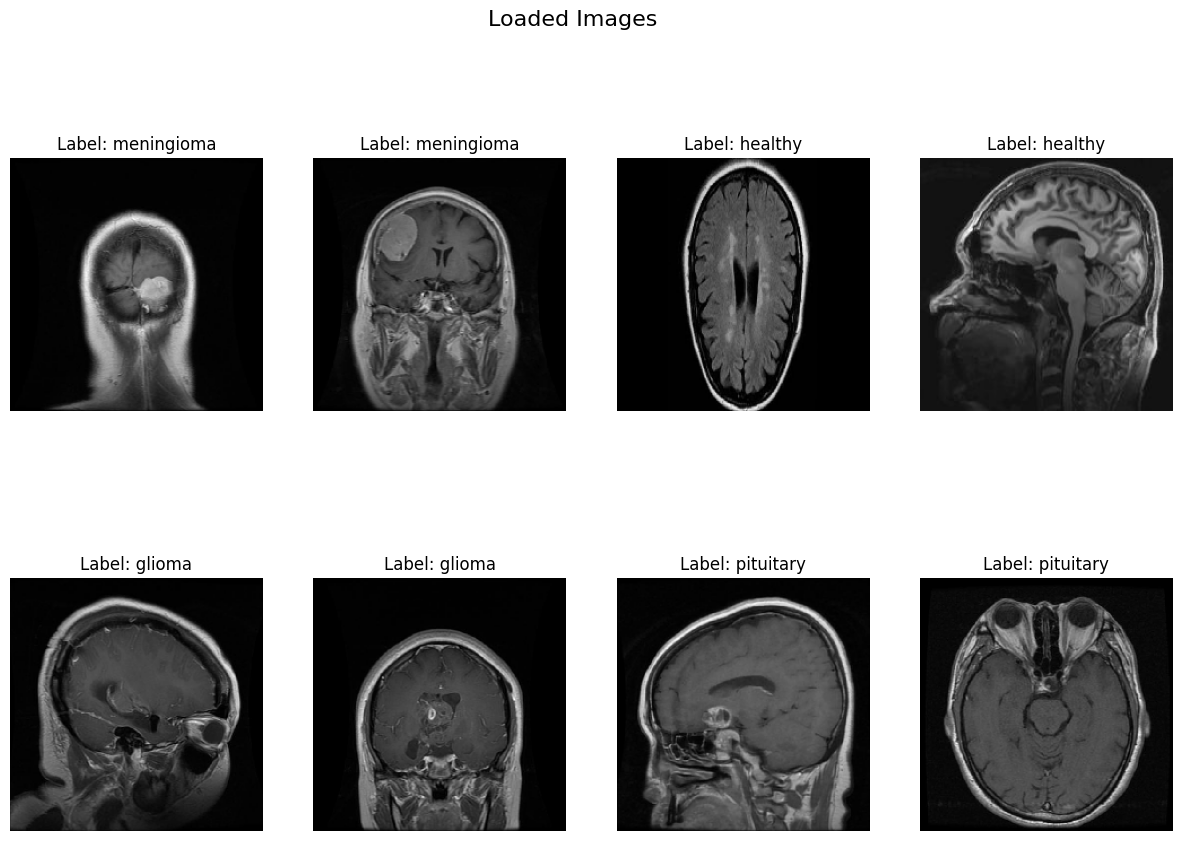

In [9]:
def display_images(images, labels):
    num_images = len(images)
    cols = 4
    rows = math.ceil(num_images / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.suptitle("Loaded Images", fontsize=16)
    axes = axes.flatten()
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image.astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.show()

display_images(images, labels)


In [17]:
def classify_image_gemini(model, image, retry_policy):
    prompt = [
    "Please classify the attached brain MRI scan into one of the following categories: glioma , meningioma , pituitary , or healthy. Respond with only the category name (e.g., Glioma).",
    Image.fromarray(image.astype("uint8")),
]

    try:
        response = model.generate_content(prompt, request_options=retry_policy)
        classification = response.text.strip().lower()
        return classification
    except Exception as e:
        print(f"Error during classification: {e}")
        return None

In [19]:
def display_results(results):
    print("\nClassification Results:")
    print(f"{'Actual Label':<20} {'Predicted Label':<20} {'Explanation':<50}")
    print("-" * 90)
    for actual, predicted, explanation in results:
        print(f"{actual:<20} {predicted:<20} {explanation:<50}")

In [20]:
results = []
for idx, (image, label) in enumerate(zip(images, labels)):
    print(f"\nProcessing Image {idx + 1}/{len(images)} - Actual Label: {label}")
    classification = classify_image_gemini(model, image, retry_policy)
    if classification is None:
        print("Classification failed.")
        results.append((idx, label, "Error", "N/A"))
        continue
    print(f"Gemini Classification: {classification}")
    is_correct = classification == label
    print("Correct Classification." if is_correct else "Incorrect Classification.")
    results.append((idx, label, classification, "Correct" if is_correct else "Incorrect"))

def display_classification_results(results):
    print("\nClassification Results:")
    print(f"{'Image Index':<12} {'Actual Label':<15} {'Predicted Label':<15} {'Result':<10}")
    print("-" * 55)
    for idx, actual, predicted, result in results:
        print(f"{idx:<12} {actual:<15} {predicted:<15} {result:<10}")

display_classification_results(results)


Processing Image 1/8 - Actual Label: meningioma
Gemini Classification: pituitary
Incorrect Classification.

Processing Image 2/8 - Actual Label: meningioma
Gemini Classification: meningioma
Correct Classification.

Processing Image 3/8 - Actual Label: healthy
Gemini Classification: healthy
Correct Classification.

Processing Image 4/8 - Actual Label: healthy
Gemini Classification: healthy
Correct Classification.

Processing Image 5/8 - Actual Label: glioma
Gemini Classification: glioma
Correct Classification.

Processing Image 6/8 - Actual Label: glioma
Gemini Classification: pituitary
Incorrect Classification.

Processing Image 7/8 - Actual Label: pituitary
Gemini Classification: meningioma
Incorrect Classification.

Processing Image 8/8 - Actual Label: pituitary
Gemini Classification: pituitary
Correct Classification.

Classification Results:
Image Index  Actual Label    Predicted Label Result    
-------------------------------------------------------
0            meningioma      p

In [23]:
def explain_misclassification_gemini(model, image, actual_label, predicted_label, retry_policy):
    prompt = [
        f"The image was classified as '{predicted_label}' but the actual label is '{actual_label}'. Please provide a brief explanation for the misclassification.",
        Image.fromarray(image.astype("uint8")),
    ]
    try:
        response = model.generate_content(prompt, request_options=retry_policy)
        explanation = response.text.strip()
        return explanation
    except Exception as e:
        print(f"Error during explanation: {e}")
        return "Explanation Failed"

explanations = []

for idx, (image_idx, actual_label, predicted_label, result) in enumerate(results):
    if result == "Incorrect":
        print(f"\nProcessing Misclassified Image {image_idx} | Actual: {actual_label} | Predicted: {predicted_label}")

        image = images[image_idx]
        explanation = explain_misclassification_gemini(model, image, actual_label, predicted_label, retry_policy)
        print(f"Explanation: {explanation}")
        explanations.append((image_idx, actual_label, predicted_label, explanation))

print("\nExplanations for Misclassifications:")
for explanation in explanations:
    print(f"Image Index: {explanation[0]}, Actual Label: {explanation[1]}, Predicted Label: {explanation[2]}, Explanation: {explanation[3]}")



Processing Misclassified Image 0 | Actual: meningioma | Predicted: pituitary
Explanation: The misclassification of this meningioma as a pituitary adenoma is likely due to the image's limited resolution and the location of the mass.  The tumor appears in the sellar/suprasellar region, a location commonly associated with pituitary adenomas.  The relatively round shape and apparent homogenous signal intensity in this particular view could also mimic a pituitary tumor.  However, a meningioma arising in this region can present with similar imaging characteristics, especially on lower-resolution images or those lacking contrast enhancement.  Higher resolution imaging with contrast and potentially different image planes would be needed to reliably differentiate between the two.  The subtle differences in margins, surrounding brain structures, and enhancement patterns that would distinguish a meningioma from a pituitary adenoma might be insufficiently evident in this particular image.

Proces